In [16]:
# Imports e paths
from pathlib import Path
import json, re, ast
from datetime import datetime, timezone
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Este notebook deve estar na RAIZ do projeto
ROOT = Path.cwd()
DATA = ROOT / "data"
PROCESSED = DATA / "processed"
INTERIM = DATA / "interim"
REPORTS = ROOT / "reports"
FIGS = REPORTS / "figs"
EXPORT = DATA / "exports" / "dashboard"

FIGS.mkdir(parents=True, exist_ok=True)
EXPORT.mkdir(parents=True, exist_ok=True)

print("ROOT:", ROOT)

ROOT: c:\Users\User\Desktop\TCC\Notebooks locais\analise_topicos_tcc


In [17]:
# Funções auxiliares

def _latest_compare_csv(results_root: Path) -> Path | None:
    """
    Retorna o CSV mais recente gerado pelo compare_models:
    results/comparison/run_YYYYmmddTHHMMSSZ/all_trials_gr_rz.csv
    """
    comp = results_root / "comparison"
    if not comp.exists():
        return None
    runs = sorted(comp.glob("run_*"))
    if not runs:
        return None
    latest = runs[-1]
    csv = latest / "all_trials_gr_rz.csv"
    return csv if csv.exists() else None

def _pick_best_bertopic(csv: Path, max_outliers=0.30, k_min=5):
    """
    Seleciona o melhor trial de BERTopic com base em RZ_index (tie-break GR_index),
    filtrando por cobertura mínima (1 - outliers) e K mínimo.
    """
    df = pd.read_csv(csv)
    cand = df[(df["method"]=="bertopic") & (df["K"]>=k_min)].copy()
    if "outliers_pct" in cand.columns:
        cand = cand[cand["outliers_pct"] <= max_outliers]
    if cand.empty:
        # fallback: sem filtro de cobertura
        cand = df[df["method"]=="bertopic"].copy()
    cand = cand.sort_values(["RZ_index","GR_index"], ascending=False)
    assert not cand.empty, "Nenhum trial BERTopic encontrado no CSV."
    return cand.iloc[0].to_dict()

def _trial_dir_bertopic(bt_root: Path, run: str, trial: str) -> Path:
    """
    Resolve o path do trial dado run e trial, cobrindo run_* e trials 'soltos' na raiz.
    """
    if isinstance(run, str) and run.startswith("run_"):
        return bt_root / run / trial
    return bt_root / trial

def _parse_representation(val):
    """
    Converte a coluna 'Representation' (string com lista) em lista de termos.
    """
    if isinstance(val, (list, tuple)):
        return [str(x) for x in val]
    try:
        lst = ast.literal_eval(str(val))
        if isinstance(lst, (list, tuple)):
            return [str(x) for x in lst]
    except Exception:
        pass
    # fallback: tokeniza por espaço
    return [t for t in str(val).split() if t]

def _load_topic_labels(tdir: Path, topn_terms=5):
    """
    Retorna dict {topic_id: label}, priorizando 'topic_info.csv' (Name/Representation).
    Faz fallback usando c_tf_idf + vocab se necessário.
    """
    labels = {}
    tip = tdir / "topic_info.csv"
    if tip.exists():
        df = pd.read_csv(tip)
        if "Topic" in df.columns:
            for _, row in df.iterrows():
                tid = int(row["Topic"])
                if tid == -1:
                    continue
                name = str(row.get("Name", "")).strip()
                if name:
                    labels[tid] = name
                else:
                    reps = None
                    if "Representation" in df.columns:
                        reps = _parse_representation(row["Representation"])
                    if reps:
                        labels[tid] = ", ".join(reps[:topn_terms])

    missing = [t for t in range(max(labels.keys())+1 if labels else 0) if t not in labels]
    ctf_p = tdir / "c_tf_idf.npy"
    voc_p = tdir / "vocab.txt"
    if missing and ctf_p.exists() and voc_p.exists():
        ctf = np.load(ctf_p)
        vocab = [line.strip() for line in open(voc_p, encoding="utf-8")]
        for tid in range(ctf.shape[0]):
            if tid in labels:
                continue
            row = ctf[tid]
            idx = np.argsort(-row)[:topn_terms]
            labels[tid] = ", ".join(vocab[i] for i in idx)

    return labels

In [18]:
# Seleção automática do melhor BERTopic
compare_csv = _latest_compare_csv(ROOT / "results")
assert compare_csv is not None and compare_csv.exists(), "Rode compare_models antes (CSV de comparação não encontrado)."

best = _pick_best_bertopic(compare_csv, max_outliers=0.30, k_min=5)
best_run, best_trial, K = best["run"], best["trial"], int(best["K"])
print("Selecionado:", best_run, best_trial, "| K =", K)

BT_ROOT = PROCESSED / "bertopic"
TRIAL_DIR = _trial_dir_bertopic(BT_ROOT, best_run, best_trial)
assert TRIAL_DIR.exists(), f"Pasta do trial não encontrada: {TRIAL_DIR}"

print("TRIAL_DIR:", TRIAL_DIR)

Selecionado: run_20250831T230602Z trial_24 | K = 12
TRIAL_DIR: c:\Users\User\Desktop\TCC\Notebooks locais\analise_topicos_tcc\data\processed\bertopic\run_20250831T230602Z\trial_24


In [19]:
# Carrega meta e doc→tópico; NORMALIZA nomes; monta cruzamentos e probabilidades

import unicodedata, re

def _keyify_name(x: str) -> str:
    x = str(x).strip()
    x = re.sub(r"\s+", " ", x)                 # espaços múltiplos -> um
    x = re.sub(r"\s+([,.;:])", r"\1", x)       # remove espaço ANTES de pontuação
    x = x.replace(" ,", ",").replace(" .", ".")
    x = unicodedata.normalize("NFKD", x)
    x = "".join(c for c in x if not unicodedata.combining(c))  # remove acentos
    x = x.lower()
    x = re.sub(r"[^a-z0-9 ,.\-]", "", x)       # mantém apenas caracteres comuns
    x = re.sub(r"\s+", " ", x).strip()
    return x

# Meta de BERTopic (mesmo CSV usado na modelagem)
prep_csv = INTERIM / "bertopic" / "prep.csv"
assert prep_csv.exists(), f"Meta não encontrada: {prep_csv}"

meta = pd.read_csv(prep_csv, encoding="utf-8")
assert "DOC_ID" in meta.columns, "prep.csv precisa conter coluna DOC_ID"

# Detecta automaticamente a coluna do orientador
cand_cols = [c for c in meta.columns if "orient" in c.lower()]
assert cand_cols, f"Coluna de orientador não encontrada em {prep_csv}."
col_orient = cand_cols[0]

meta = meta[["DOC_ID", col_orient]].rename(columns={col_orient: "orientador"})
meta["DOC_ID"] = meta["DOC_ID"].astype(int)
meta["orientador"] = meta["orientador"].astype(str).fillna("NA").str.strip()

# === NORMALIZAÇÃO ANTES DA JUNÇÃO E DAS CONTAGENS ===
meta["_key"] = meta["orientador"].map(_keyify_name)
name_map = meta.groupby("_key")["orientador"] \
               .agg(lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0]) \
               .to_dict()
meta["orientador"] = meta["_key"].map(name_map)
meta = meta.drop(columns=["_key"]).copy()

# Doc→tópico (ignora outliers -1)
labels = pd.read_csv(TRIAL_DIR / "doc_topics.csv", encoding="utf-8")
assert {"DOC_ID","topic"}.issubset(labels.columns), "doc_topics.csv precisa conter DOC_ID e topic"
labels["DOC_ID"] = labels["DOC_ID"].astype(int)
labels = labels[labels["topic"] != -1].copy()

# Junção já com orientadores normalizados
df = labels.merge(meta, on="DOC_ID", how="inner")
assert not df.empty, "Junção vazia; verifique se DOC_ID bate entre prep.csv e doc_topics.csv"

# Contagens
ct_ot = df.groupby(["orientador","topic"]).size().rename("n").reset_index()
ct_o  = df.groupby("orientador").size().rename("n_o")
ct_t  = df.groupby("topic").size().rename("n_t")
N_assigned = len(df)                   # docs com tópico (sem -1)
N_total_meta = meta.shape[0]           # total de docs na base meta

# Probabilidades com suavização leve (evita zeros)
alpha = 0.5

# P(tópico | orientador): linhas=orientador, colunas=topic
p_t_given_o = ct_ot.pivot(index="orientador", columns="topic", values="n").fillna(0.0)
p_t_given_o = (p_t_given_o + alpha)
p_t_given_o = p_t_given_o.div(p_t_given_o.sum(axis=1), axis=0)

# P(orientador | tópico): linhas=topic, colunas=orientador
p_o_given_t = ct_ot.pivot(index="topic", columns="orientador", values="n").fillna(0.0)
p_o_given_t = (p_o_given_t + alpha)
p_o_given_t = p_o_given_t.div(p_o_given_t.sum(axis=1), axis=0)

# P(tópico) marginal (sobre docs alocados)
p_t = (ct_t + alpha) / (N_assigned + alpha * len(ct_t))
p_t = p_t.astype(float)

# Lift logarítmico: log( P(t|o) / P(t) )
lift = p_t_given_o.copy()
for t in lift.columns:
    lift[t] = np.log(p_t_given_o[t] / float(p_t.loc[t]))

# Cobertura por orientador: fração de docs do orientador que receberam tópico (≠ -1)
docs_por_orientador_total = meta.groupby("orientador").size().rename("n_total")
docs_por_orientador_assigned = df.groupby("orientador").size().rename("n_assigned")
coverage_orientador = pd.concat([docs_por_orientador_total, docs_por_orientador_assigned], axis=1).fillna(0)
coverage_orientador["coverage"] = coverage_orientador["n_assigned"] / coverage_orientador["n_total"].replace(0, np.nan)
coverage_orientador = coverage_orientador.reset_index()

In [23]:
# Rótulos de tópicos e tabelas finais (long format + Top-N por orientador)
topic_labels = _load_topic_labels(TRIAL_DIR, topn_terms=5)

# Long format com P(t|o), lift, contagens
long_rows = []
for o, row in p_t_given_o.iterrows():
    n_o_assigned = int(ct_o.get(o, 0))
    if o in coverage_orientador["orientador"].values:
        n_o_total = int(coverage_orientador.set_index("orientador").loc[o, "n_total"])
        cov_o = float(coverage_orientador.set_index("orientador").loc[o, "coverage"])
    else:
        n_o_total = n_o_assigned
        cov_o = n_o_assigned / max(n_o_total, 1)

    for t, pto in row.items():
        long_rows.append({
            "orientador": o,
            "topic": int(t),
            "topic_label": topic_labels.get(int(t), f"topic_{t}"),
            "P_topic_given_orientador": float(pto),
            "lift_log": float(lift.loc[o, t]),
            "n_docs_orientador_total": n_o_total,
            "n_docs_orientador_assigned": n_o_assigned,
            "coverage_orientador": cov_o,
            "n_docs_topic": int(ct_t.get(t, 0)),
        })

topics_by_orientador = pd.DataFrame(long_rows).sort_values(
    ["orientador", "P_topic_given_orientador"], ascending=[True, False]
)

# --- Top-N por orientador com critérios de estabilidade ---
MIN_DOCS_TOTAL = 3      # nº mínimo de TCCs do orientador na base inteira
MIN_COVERAGE   = 0.50   # fração mínima de TCCs do orientador que receberam tópico (≠ -1)
TOPN = 3

# junta métricas de cobertura n_total/coverage
stab = coverage_orientador.set_index("orientador")[["n_total", "coverage"]]

# filtra: orientadores estáveis e tópicos com lift positivo
tb = topics_by_orientador.merge(stab, left_on="orientador", right_index=True, how="left")
tb = tb[
    (tb["n_total"].fillna(0).astype(int) >= MIN_DOCS_TOTAL) &
    (tb["coverage"].fillna(0) >= MIN_COVERAGE) &
    (tb["lift_log"] > 0)
]

# ordena por P(t|o) e desempata por lift; pega TOPN por orientador
tb = tb.sort_values(
    ["orientador", "P_topic_given_orientador", "lift_log"],
    ascending=[True, False, False]
)

orientador_top = (
    tb.groupby("orientador", group_keys=False)
      .apply(lambda g: g.head(TOPN))
      .reset_index(drop=True)
)

# tipagem/coerência final
orientador_top["topic"] = orientador_top["topic"].astype(int)

display(orientador_top.head(10))


C:\Users\User\AppData\Local\Temp\ipykernel_28588\889894393.py:56: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.head(TOPN))


,orientador,topic,topic_label,P_topic_given_orientador,lift_log,n_docs_orientador_total,n_docs_orientador_assigned,coverage_orientador,n_docs_topic,n_total,coverage
0,"ALMEIDA, Hyggo Oliveira de.",5,5_sade_animais_pandemia_dados,0.263158,0.947381,5,4,0.800000,37,5,0.800000
1,"ALMEIDA, Hyggo Oliveira de.",6,6_software_empresas_objetivo_vulnerabilidades,0.157895,0.519937,5,4,0.800000,34,5,0.800000
2,"ALMEIDA, Hyggo Oliveira de.",3,3_software_projetos_cdigo_bugs,0.157895,0.311393,5,4,0.800000,42,5,0.800000
3,"ALVES, Everton Leandro Galdino.",6,6_software_empresas_objetivo_vulnerabilidades,0.241379,0.944378,13,9,0.692308,34,13,0.692308
4,"ALVES, Everton Leandro Galdino.",3,3_software_projetos_cdigo_bugs,0.241379,0.735834,13,9,0.692308,42,13,0.692308
5,"ALVES, Everton Leandro Galdino.",5,5_sade_animais_pandemia_dados,0.103448,0.013699,13,9,0.692308,37,13,0.692308
6,"ANDRADE, Nazareno Ferreira de.",4,4_dados_digital_sobre_privacidade,0.263158,0.895422,5,4,0.800000,39,5,0.800000
7,"ANDRADE, Nazareno Ferreira de.",5,5_sade_animais_pandemia_dados,0.157895,0.436556,5,4,0.800000,37,5,0.800000
8,"ANDRADE, Nazareno Ferreira de.",0,0_modelos_dados_linguagem_imagens,0.157895,0.100083,5,4,0.800000,52,5,0.800000
9,"ANDRADE, Wilkerson de Lucena.",6,6_software_empresas_objetivo_vulnerabilidades,0.241379,0.944378,11,9,0.818182,34,11,0.818182


In [24]:
# P(orientador | tópico) em long format (bom para páginas por tópico no dashboard)
long_rows_ot = []
for t, row in p_o_given_t.iterrows():
    for o, pot in row.items():
        long_rows_ot.append({
            "topic": int(t),
            "topic_label": topic_labels.get(int(t), f"topic_{t}"),
            "orientador": o,
            "P_orientador_given_topic": float(pot),
            "n_docs_topic": int(ct_t.get(t, 0)),
            "n_docs_orientador_assigned": int(ct_o.get(o, 0))
        })
orientador_por_topico = pd.DataFrame(long_rows_ot).sort_values(
    ["topic","P_orientador_given_topic"], ascending=[True, False]
)

display(orientador_por_topico.head(10))

# ===== Exporta para o dashboard =====
run_dir = EXPORT / "bertopic_profiles" / str(best_run) / str(best_trial)
run_dir.mkdir(parents=True, exist_ok=True)

topics_by_orientador.to_csv(run_dir/"topics_by_orientador.csv", index=False, encoding="utf-8")
orientador_top.to_csv(run_dir/"orientador_top_topics.csv", index=False, encoding="utf-8")
orientador_por_topico.to_csv(run_dir/"orientador_por_topico.csv", index=False, encoding="utf-8")
coverage_orientador.to_csv(run_dir/"coverage_orientador.csv", index=False, encoding="utf-8")

# Metadados da seleção
with open(run_dir/"selection.json","w",encoding="utf-8") as f:
    json.dump({
        "selected_run": best_run,
        "selected_trial": best_trial,
        "K": int(K),
        "source_compare_csv": str(compare_csv),
        "timestamp_utc": datetime.now(timezone.utc).isoformat()
    }, f, ensure_ascii=False, indent=2)

print("Arquivos salvos em:", run_dir)

,topic,topic_label,orientador,P_orientador_given_topic,n_docs_topic,n_docs_orientador_assigned
23,0,0_modelos_dados_linguagem_imagens,"GOMES, Herman Martins.",0.110390,52,23
12,0,0_modelos_dados_linguagem_imagens,"CAMPELO, Claudio Elízio Calazans.",0.097403,52,22
28,0,0_modelos_dados_linguagem_imagens,"MARINHO, Leandro Balby.",0.058442,52,7
34,0,0_modelos_dados_linguagem_imagens,"MORAIS, Fábio Jorge Almeida.",0.058442,52,19
6,0,0_modelos_dados_linguagem_imagens,"ARAÚJO, Joseana Macêdo Fechine Régis de.",0.045455,52,13
22,0,0_modelos_dados_linguagem_imagens,"GHEYI, Rohit.",0.045455,52,10
29,0,0_modelos_dados_linguagem_imagens,"MASSONI, Tiago Lima.",0.045455,52,30
7,0,0_modelos_dados_linguagem_imagens,"BAPTISTA, Cláudio de Souza.",0.032468,52,17
21,0,0_modelos_dados_linguagem_imagens,"GHEYI, Rohit Gheyi.",0.032468,52,2
32,0,0_modelos_dados_linguagem_imagens,"MONTEIRO, João Arthur Brunet.",0.032468,52,15


Arquivos salvos em: c:\Users\User\Desktop\TCC\Notebooks locais\analise_topicos_tcc\data\exports\dashboard\bertopic_profiles\run_20250831T230602Z\trial_24


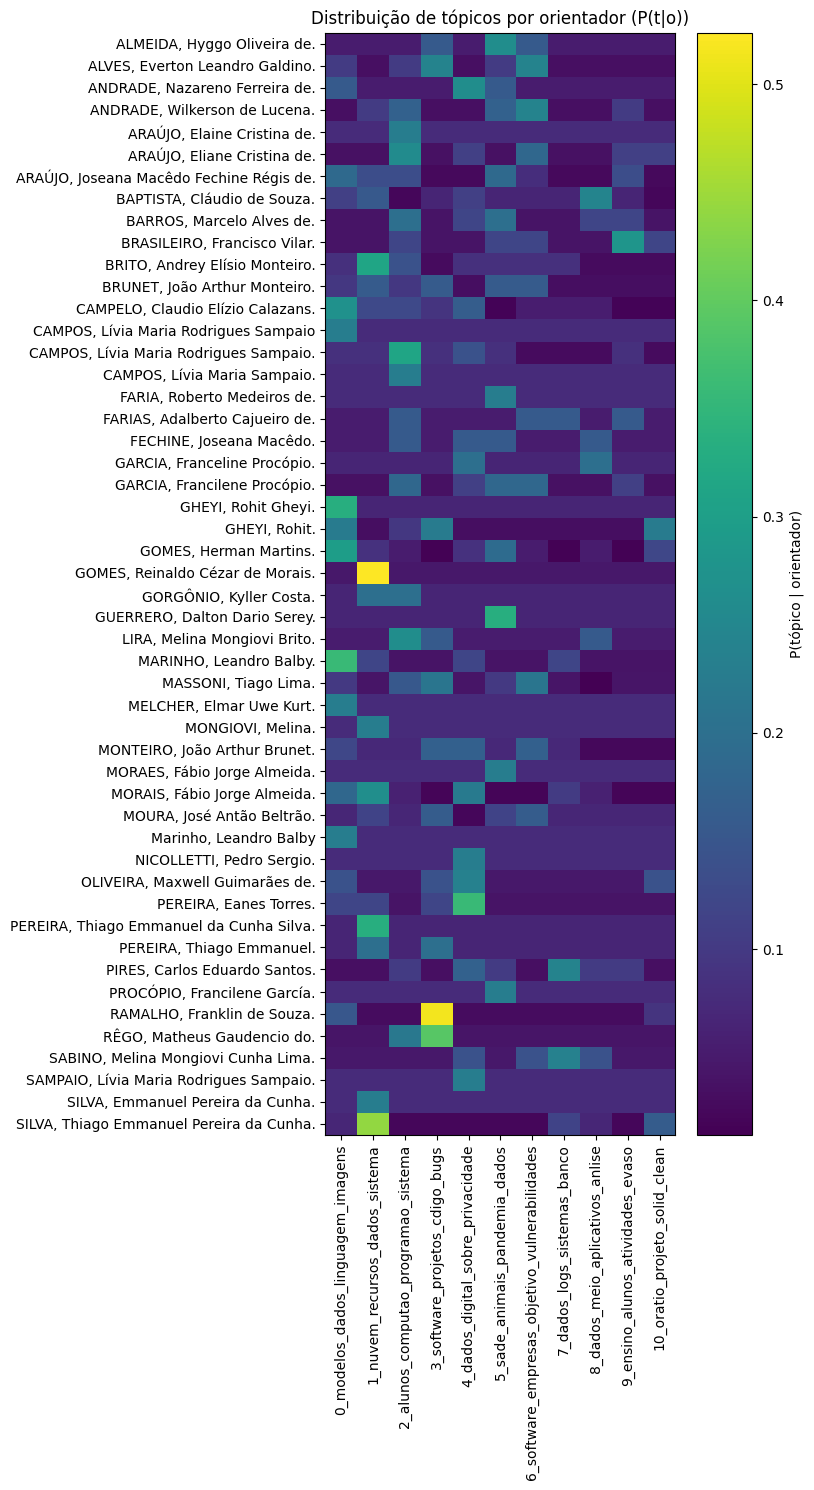

Heatmap salvo em: c:\Users\User\Desktop\TCC\Notebooks locais\analise_topicos_tcc\data\exports\dashboard\bertopic_profiles\run_20250831T230602Z\trial_24\heatmap_orientador_vs_topic.png


In [25]:
# Heatmap opcional (P(t|o)) — útil para validar visualmente
plt.figure(figsize=(max(8, len(p_t_given_o.columns)*0.6), max(6, len(p_t_given_o)*0.3)))
plt.imshow(p_t_given_o.values, aspect='auto', interpolation='nearest')
plt.colorbar(label="P(tópico | orientador)")
plt.yticks(range(len(p_t_given_o.index)), p_t_given_o.index)
plt.xticks(range(len(p_t_given_o.columns)), [topic_labels.get(int(t), t) for t in p_t_given_o.columns], rotation=90)
plt.title("Distribuição de tópicos por orientador (P(t|o))")
plt.tight_layout()
out_png = (EXPORT / "bertopic_profiles" / str(best_run) / str(best_trial) / "heatmap_orientador_vs_topic.png")
plt.savefig(out_png, dpi=150)
plt.show()
print("Heatmap salvo em:", out_png)